In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [16]:
from xgboost import XGBClassifier


In [5]:
import numpy as np
import pandas as pd

np.random.seed(42)
n_customers = 5000

df = pd.DataFrame({
    "customer_id": np.arange(1, n_customers + 1),
    "age": np.random.randint(18, 65, size=n_customers),
    "gender": np.random.choice(["Male", "Female"], size=n_customers),
    "country": np.random.choice(["Germany", "France", "Spain", "Italy"], size=n_customers),
    "tenure_months": np.random.randint(1, 60, size=n_customers),
    "total_orders": np.random.poisson(10, size=n_customers),
    "avg_order_value": np.random.normal(40, 15, size=n_customers).clip(5),
    "app_opens_per_month": np.random.poisson(20, size=n_customers),
    "support_tickets_raised": np.random.poisson(1, size=n_customers),
    "is_premium_member": np.random.choice([0, 1], size=n_customers, p=[0.7, 0.3]),
    "used_coupon_last_month": np.random.choice([0, 1], size=n_customers, p=[0.6, 0.4]),
})

base = 0.2

p_churn = (
    base
    + (df['tenure_months'] < 6) * 0.20
    + (df['total_orders'] < 3) * 0.15
    + (df['app_opens_per_month'] < 5) * 0.15
    + (df['support_tickets_raised'] >= 3) * 0.10
    - df['is_premium_member'] * 0.12
    - df['used_coupon_last_month'] * 0.07
)

p_churn = p_churn.clip(0.05, 0.9)
df['churned'] = np.random.binomial(1, p_churn)

df.head()


,customer_id,age,gender,country,tenure_months,total_orders,avg_order_value,app_opens_per_month,support_tickets_raised,is_premium_member,used_coupon_last_month,churned
0,1,56,Male,Germany,54,9,81.095232,24,0,1,0,0
1,2,46,Female,Germany,11,8,71.859857,20,3,0,0,1
2,3,32,Male,France,53,12,42.160176,25,2,0,0,0
3,4,60,Male,Germany,8,6,46.512130,18,1,0,0,0
4,5,25,Male,Germany,25,16,43.763822,24,3,1,0,0


In [6]:
df.head()

,customer_id,age,gender,country,tenure_months,total_orders,avg_order_value,app_opens_per_month,support_tickets_raised,is_premium_member,used_coupon_last_month,churned
0,1,56,Male,Germany,54,9,81.095232,24,0,1,0,0
1,2,46,Female,Germany,11,8,71.859857,20,3,0,0,1
2,3,32,Male,France,53,12,42.160176,25,2,0,0,0
3,4,60,Male,Germany,8,6,46.512130,18,1,0,0,0
4,5,25,Male,Germany,25,16,43.763822,24,3,1,0,0


In [7]:
df.info()
df.describe()
df['churned'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             5000 non-null   int64  
 1   age                     5000 non-null   int32  
 2   gender                  5000 non-null   object 
 3   country                 5000 non-null   object 
 4   tenure_months           5000 non-null   int32  
 5   total_orders            5000 non-null   int32  
 6   avg_order_value         5000 non-null   float64
 7   app_opens_per_month     5000 non-null   int32  
 8   support_tickets_raised  5000 non-null   int32  
 9   is_premium_member       5000 non-null   int64  
 10  used_coupon_last_month  5000 non-null   int64  
 11  churned                 5000 non-null   int32  
dtypes: float64(1), int32(6), int64(3), object(2)
memory usage: 351.7+ KB


churned
0    4220
1     780
Name: count, dtype: int64

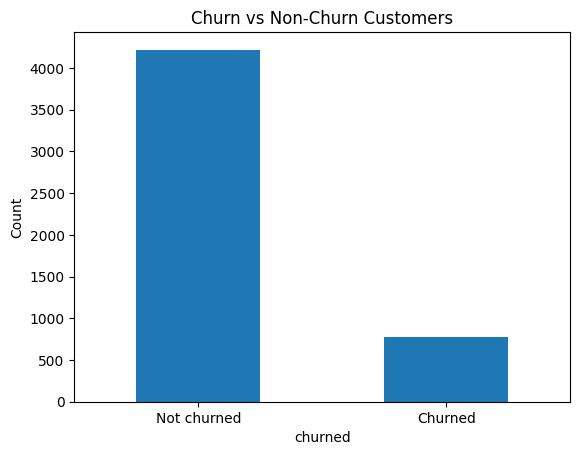

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn vs Non-churn
df['churned'].value_counts().plot(kind='bar')
plt.xticks([0,1], ['Not churned', 'Churned'], rotation=0)
plt.title('Churn vs Non-Churn Customers')
plt.ylabel('Count')
plt.show()


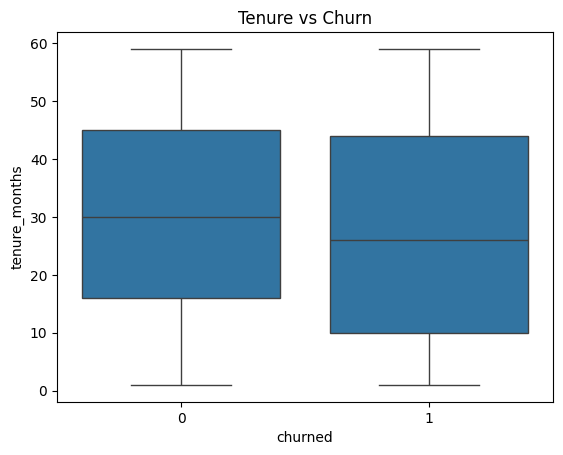

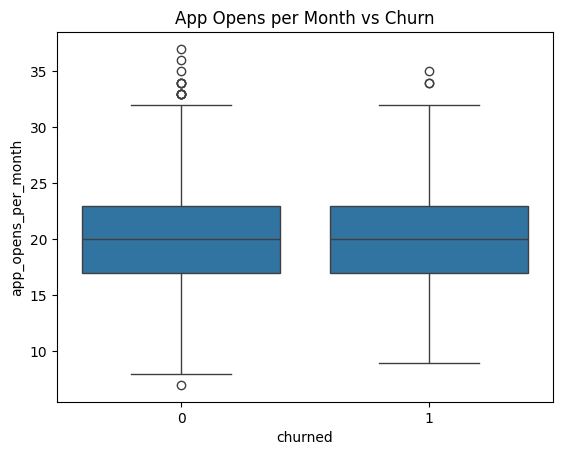

In [9]:
# Tenure vs churn
sns.boxplot(x='churned', y='tenure_months', data=df)
plt.title('Tenure vs Churn')
plt.show()

# App opens vs churn
sns.boxplot(x='churned', y='app_opens_per_month', data=df)
plt.title('App Opens per Month vs Churn')
plt.show()


In [10]:
df_encoded = pd.get_dummies(df, columns=['gender', 'country'], drop_first=True)
df_encoded.head()


,customer_id,age,tenure_months,total_orders,avg_order_value,app_opens_per_month,support_tickets_raised,is_premium_member,used_coupon_last_month,churned,gender_Male,country_Germany,country_Italy,country_Spain
0,1,56,54,9,81.095232,24,0,1,0,0,True,True,False,False
1,2,46,11,8,71.859857,20,3,0,0,1,False,True,False,False
2,3,32,53,12,42.160176,25,2,0,0,0,True,False,False,False
3,4,60,8,6,46.512130,18,1,0,0,0,True,True,False,False
4,5,25,25,16,43.763822,24,3,1,0,0,True,True,False,False


In [11]:
X = df_encoded.drop(['churned', 'customer_id'], axis=1)
y = df_encoded['churned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((4000, 12), (1000, 12))

In [12]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


In [17]:
# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'   # warning टाळायला
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


In [18]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

print("🔹 Random Forest Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))
print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, y_pred))

print("\n\n🔹 XGBoost Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification Report (XGBoost):\n")
print(classification_report(y_test, y_pred_xgb))


🔹 Random Forest Performance
Accuracy: 0.838
ROC-AUC: 0.6116630210232106

Classification Report (Random Forest):

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       844
           1       0.12      0.01      0.01       156

    accuracy                           0.84      1000
   macro avg       0.48      0.50      0.46      1000
weighted avg       0.73      0.84      0.77      1000



🔹 XGBoost Performance
Accuracy: 0.836
ROC-AUC: 0.6007716611982015

Classification Report (XGBoost):

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       844
           1       0.38      0.08      0.13       156

    accuracy                           0.84      1000
   macro avg       0.61      0.53      0.52      1000
weighted avg       0.78      0.84      0.79      1000



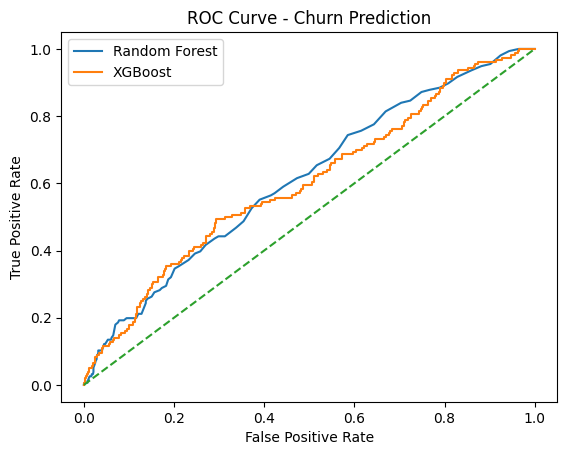

In [19]:
from sklearn.metrics import roc_curve

# RF probabilities
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Churn Prediction')
plt.legend()
plt.show()


In [20]:
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
xgb_top_features = xgb_importances.sort_values(ascending=False).head(10)

xgb_top_features


is_premium_member         0.223974
used_coupon_last_month    0.089684
tenure_months             0.078829
avg_order_value           0.071082
age                       0.069613
country_Germany           0.069442
country_Italy             0.068788
support_tickets_raised    0.067875
country_Spain             0.067295
total_orders              0.066201
dtype: float32

Accuracy: 0.838

Classification report:

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       844
           1       0.12      0.01      0.01       156

    accuracy                           0.84      1000
   macro avg       0.48      0.50      0.46      1000
weighted avg       0.73      0.84      0.77      1000



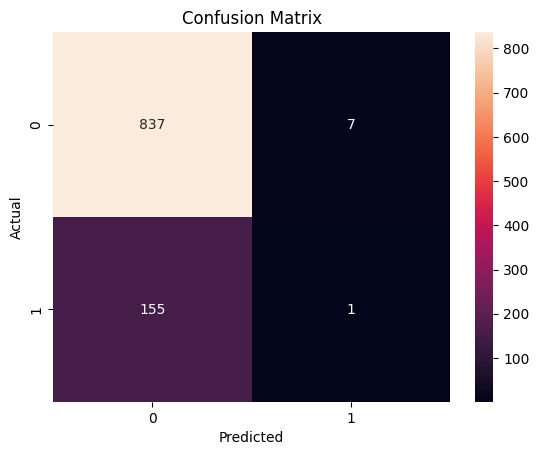

In [13]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)
top_features


avg_order_value           0.186854
tenure_months             0.181981
age                       0.157844
app_opens_per_month       0.128948
total_orders              0.118661
support_tickets_raised    0.061948
is_premium_member         0.052377
gender_Male               0.026743
used_coupon_last_month    0.026217
country_Spain             0.019941
dtype: float64

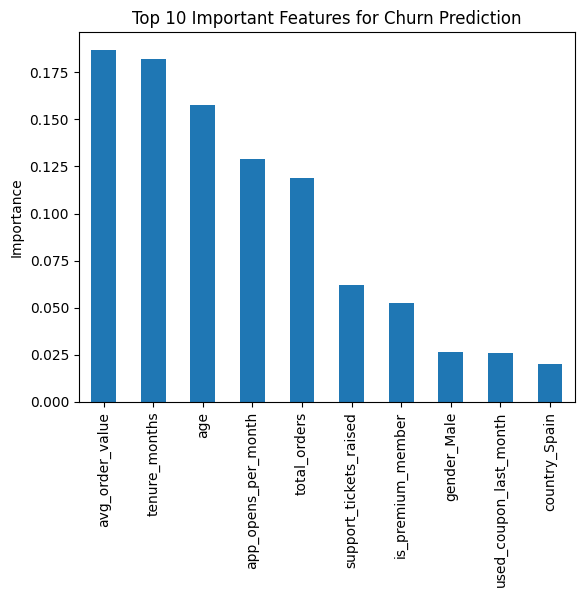

In [15]:
top_features.plot(kind='bar')
plt.title('Top 10 Important Features for Churn Prediction')
plt.ylabel('Importance')
plt.show()


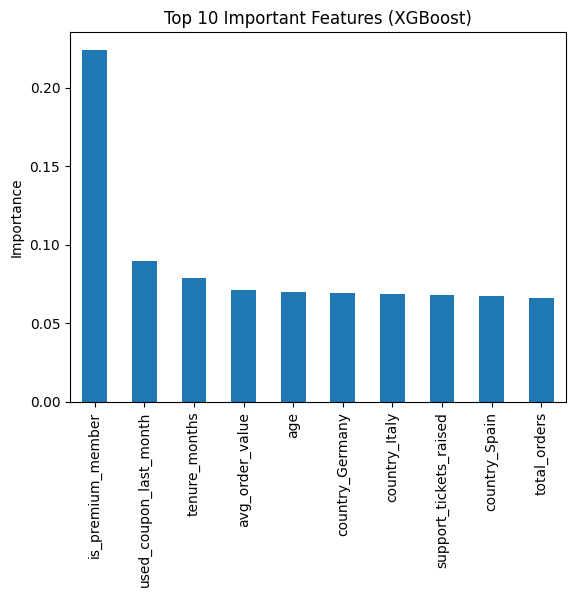

In [21]:
xgb_top_features.plot(kind='bar')
plt.title('Top 10 Important Features (XGBoost)')
plt.ylabel('Importance')
plt.show()
